In [2]:
import xarray as xr
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import glob
import cartopy.crs as ccrs
from scipy.stats import gaussian_kde
import numpy.ma as ma
import math

In [3]:
dem=xr.open_dataset('/g/data/dt55/wil_outputs/dem_aus.nc')#,parallel=True,lock=False)
source_ds=dem.rename_vars({'ASCIITo_asc1':'dem'})

In [4]:
## Some useful functions
# Make a Cartopy Projection Object from netcdf Proj info
def get_ccrs_from_proj(ds):
    import cartopy.crs as ccrs
    if 'proj' in ds.variables:
        try:
            return ccrs.AlbersEqualArea(central_longitude=ds.proj.attrs['longitude_of_central_meridian'],
                            central_latitude=ds.proj.attrs['latitude_of_projection_origin'],
                            false_easting=ds.proj.attrs['false_easting'],
                            false_northing=ds.proj.attrs['false_northing'],
                            standard_parallels=ds.proj.attrs['standard_parallel'],
                            globe=None)
        except Exception as err:
            print(err)
            return ccrs.PlateCarree()


# define color table for RF3
class cmap_rf3(object):
    """Define color maps for RF3 rainfall products."""

    from matplotlib.colors import ListedColormap
    import matplotlib.pyplot as plt

    # RAINFALL
    rainfall_colors = np.array([(255, 255, 255),  # 0.0
                                (245, 245, 255),  # 0.2
                                (180, 180, 255),  # 0.5
                                (120, 120, 255),  # 1.5
                                (20,  20, 255),  # 2.5
                                (0, 216, 195),  # 4.0
                                (0, 150, 144),  # 6.0
                                (0, 102, 102),  # 10
                                (255, 255,   0),  # 15
                                (255, 200,   0),  # 20
                                (255, 150,   0),  # 30
                                (255, 100,   0),  # 40
                                (255,   0,   0),  # 50
                                (200,   0,   0),  # 60
                                (120,   0,   0),  # 75
                                (100,   0,   0)])  # > 100
    rainfall_colors = rainfall_colors/255.
    #cm_rainfall = 'blues'
    cm_rainfall = ListedColormap(rainfall_colors, 'blues')
    rainfall_levels = [600., 700, 800, 900, 1000,
                          1100, 1200, 1300, 1400, 1500, 1600,]        
    rainfall_levels_hr = [600., 700, 800, 900, 1000,
                          1100, 1200, 1300, 1400, 1500, 1600,]        
    rainfall_levels_10min = [600., 700, 800, 900, 1000,
                          1100, 1200, 1300, 1400, 1500, 1600,]  
    rainfall_levels_m = [0,20,40,60,80,100,120,140,160,180,200,220,240,260]
        
def transform_coords_from_km_to_m(ds):
    """Transform coords from km to m (if required)."""
    if ds is not None:
        if 'x' in ds.coords:
            if 'units' in ds.x.attrs:
                if ds.x.units == 'km':
                    ds['x'] = ds.x*1000.
                    ds.x.attrs.update({'units': 'm'})
                    ds.x.attrs.update(
                        {'standard_name':
                         'projection_x_coordinate'})
                    message = '; Original coords x transformed to m from km'
                    if 'history' in ds.attrs:
                        ds.attrs['history'] += message
                    else:
                        ds.attrs['history'] = message
                if ds.y.units == 'km':
                    ds['y'] = ds.y*1000.
                    ds.y.attrs.update({'units': 'm'})
                    ds.y.attrs.update(
                        {'standard_name':
                         'projection_y_coordinate'})
                    ds.attrs['history'] += '; Original coords y transformed to m from km'
    return ds

def preprocess_radar(ds):
    ds = transform_coords_from_km_to_m(ds)
    if 'n2' in ds.dims:
        ds = ds.drop_dims('n2')
    return ds

def get_projection_from_dataset(rainfall):
    """Return a cartopy projection object from a dataset."""
    try:
        if ('proj' in rainfall.data_vars):
            proj = rainfall.variables['proj']
            if (proj.attrs['grid_mapping_name'] ==
                    "albers_conical_equal_area"):
                projection = ccrs.AlbersEqualArea(
                    central_longitude=proj.attrs['longitude_of_central_meridian'],
                    central_latitude=proj.attrs['latitude_of_projection_origin'],
                    standard_parallels=proj.attrs['standard_parallel'],
                    )
            elif (getattr(proj, 'grid_mapping_name') ==
                    "gnomonic"):
                print('Projection is gnomonic')
                projection = ccrs.Gnomonic(
                    central_longitude=proj.attrs['longitude_of_projection_origin'],
                    central_latitude=proj.attrs['latitude_of_projection_origin'],
                    )
        else:
            print("INFO: Assuming standard PlateCarree projection")
            projection = ccrs.PlateCarree()
        return projection
    except Exception as err:
        print(err)
        return None

def get_coords_from_dataset(rainfall):
    """Return coordinates in a dataset."""
    try:
        if ('lat' in rainfall.coords):
            x = rainfall['lon'][:].data
            y = rainfall['lat'][:].data
        elif ('x' in rainfall.coords):
            x = rainfall['x'][:].data
            y = rainfall['y'][:].data
            if (rainfall['x'].units == 'km'):
                factor = 1000.
                x = x * factor
                y = y * factor
        else:
            x = np.array(None)
            y = np.array(None)
        return x, y
    except Exception as err:
        print(err)
        return None, None

In [5]:
victas_tile='/g/data/dt55/pst/projection/PST_tile_T22-Vic-TAS_projection.nc'
victas_tile_ds=xr.open_dataset(victas_tile)

In [6]:
my_hourly_files="/home/565/dm2042/WIL/Mean-data/victas_mean-hour-*.nc"
my_hourly_mean_ds=xr.open_mfdataset(
    my_hourly_files,
    combine='nested',
    concat_dim='hour',
    parallel=True,
    lock=False,
    ).sortby('hour')
my_hourly_mean_ds

<xarray.Dataset>
Dimensions:        (hour: 24, x: 512, y: 512)
Coordinates:
  * y              (y) float64 -4.911e+06 -4.909e+06 ... -3.891e+06 -3.889e+06
  * x              (x) float64 6.89e+05 6.91e+05 ... 1.709e+06 1.711e+06
  * hour           (hour) int64 0 1 2 3 4 5 6 7 8 ... 15 16 17 18 19 20 21 22 23
Data variables:
    precipitation  (hour, y, x) float32 dask.array<chunksize=(1, 512, 512), meta=np.ndarray>

In [7]:
target_proj_v = get_projection_from_dataset(victas_tile_ds)

In [8]:
target_x_points_v, target_y_points_v = get_coords_from_dataset(victas_tile_ds)
coord_x_grid_target_v, coord_y_grid_target_v = np.meshgrid(target_x_points_v,
                                                           target_y_points_v)
proj_info_v = victas_tile_ds.proj.copy()

In [9]:
source_proj_v = get_projection_from_dataset(source_ds)
target_xyz = source_proj_v.transform_points(target_proj_v,
                                              coord_x_grid_target_v,
                                              coord_y_grid_target_v,
                                              )
# store new coordinates in the source projection
# as DataArray

new_y_v = xr.DataArray(target_xyz[:, :, 1],
                     dims=["y","x"],
                     coords={"x": target_x_points_v,"y":target_y_points_v})
new_x_v = xr.DataArray(target_xyz[:, :, 0],
                     dims=["y","x"],
                     coords={"x": target_x_points_v,"y":target_y_points_v})

INFO: Assuming standard PlateCarree projection


In [10]:
topo_v = source_ds['dem'].interp(lon=new_x_v,lat=new_y_v,method='nearest')
topo_v

<xarray.DataArray 'dem' (y: 512, x: 512)>
array([[       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       ...,
       [ 19.48069 ,  18.05345 ,  16.42616 , ...,  76.59721 ,  52.34126 ,
         24.72227 ],
       [ 11.6442  ,  13.9853  ,  15.66462 , ..., 357.9852  ,  48.9416  ,
         20.40425 ],
       [  7.437441,   8.403989,  11.27083 , ..., 479.9012  , 205.0974  ,
         33.26088 ]], dtype=float32)
Coordinates:
    lon      (y, x) float64 140.3 140.4 140.4 140.4 ... 150.7 150.7 150.7 150.8
    lat      (y, x) float64 -44.76 -44.76 -44.76 -44.76 ... -34.48 -34.47 -34.47
  * x        (x) float64 6.89e+05 6.91e+05 6.93e+05 ... 1.709e+06 1.711e+06
  * y        (y) float64 -4.911e+06 -4.909e+06 ... -3.891e+06 -3.889e+06
Attributes:
    long_name:       ASCIITo_asc1
    esri_pe_string:  GEOGCS["GCS_WGS_1984",DATUM["D_WGS_1984",SPHEROID["WGS_1...
    units:           Degree

In [11]:
coastal_dist_files="/scratch/dt55/dm2042/coastal_distance/inland_distance_310.nc"
coastal_dist_ds=xr.open_mfdataset(coastal_dist_files)
coastal_dist_ds

/g/data/dk92/apps/anaconda3/2020.12/envs/NCI-data-analysis_2021.03.1/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  
/g/data/dk92/apps/anaconda3/2020.12/envs/NCI-data-analysis_2021.03.1/lib/python3.7/site-packages/xarray/backends/api.py:941: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  from_openmfds=True,


<xarray.Dataset>
Dimensions:   (x: 2450, y: 2050)
Coordinates:
    lon       (y, x) float64 dask.array<chunksize=(2050, 2450), meta=np.ndarray>
    lat       (y, x) float64 dask.array<chunksize=(2050, 2450), meta=np.ndarray>
  * x         (x) float64 -2.299e+06 -2.297e+06 ... 2.597e+06 2.599e+06
  * y         (y) float64 -1.001e+06 -1.003e+06 ... -5.097e+06 -5.099e+06
Data variables:
    distance  (y, x) float32 dask.array<chunksize=(2050, 2450), meta=np.ndarray>

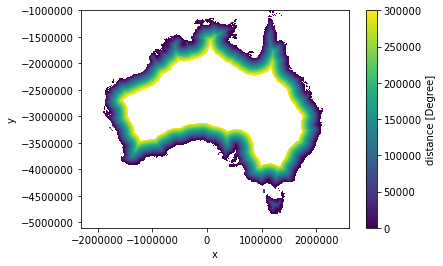

In [12]:
coastal_dist_ds.distance.plot()

In [13]:
_, coastal_dist_ds_v = xr.align(victas_tile_ds,coastal_dist_ds,join='left',)
coastal_dist_ds_v

<xarray.Dataset>
Dimensions:   (x: 512, y: 512)
Coordinates:
  * x         (x) float64 6.89e+05 6.91e+05 6.93e+05 ... 1.709e+06 1.711e+06
  * y         (y) float64 -4.911e+06 -4.909e+06 ... -3.891e+06 -3.889e+06
    lon       (y, x) float64 dask.array<chunksize=(512, 512), meta=np.ndarray>
    lat       (y, x) float64 dask.array<chunksize=(512, 512), meta=np.ndarray>
Data variables:
    distance  (y, x) float32 dask.array<chunksize=(512, 512), meta=np.ndarray>

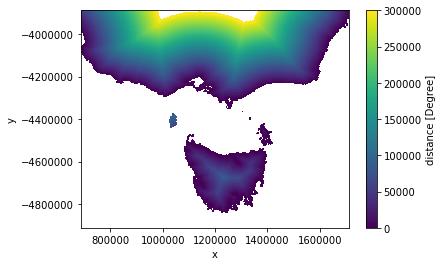

In [14]:
coastal_dist_ds_v.distance.plot()

In [15]:
_, victas_hour_mean_ds_v = xr.align(victas_tile_ds,my_hourly_mean_ds,join='left',)
victas_hour_mean_ds_v

<xarray.Dataset>
Dimensions:        (hour: 24, x: 512, y: 512)
Coordinates:
  * y              (y) float64 -4.911e+06 -4.909e+06 ... -3.891e+06 -3.889e+06
  * x              (x) float64 6.89e+05 6.91e+05 ... 1.709e+06 1.711e+06
  * hour           (hour) int64 0 1 2 3 4 5 6 7 8 ... 15 16 17 18 19 20 21 22 23
Data variables:
    precipitation  (hour, y, x) float32 dask.array<chunksize=(1, 512, 512), meta=np.ndarray>

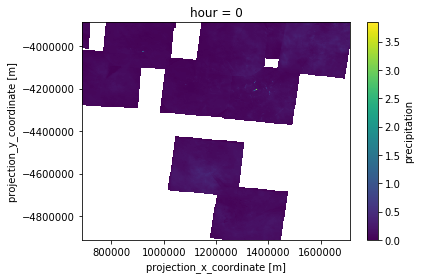

In [16]:
victas_hour_mean_ds_v.sel(hour=0).precipitation.plot()

In [18]:
full_dem_ds = victas_hour_mean_ds_v.assign(dem = topo_v.drop(['lat','lon']))
full_dem_ds

<xarray.Dataset>
Dimensions:        (hour: 24, x: 512, y: 512)
Coordinates:
  * y              (y) float64 -4.911e+06 -4.909e+06 ... -3.891e+06 -3.889e+06
  * x              (x) float64 6.89e+05 6.91e+05 ... 1.709e+06 1.711e+06
  * hour           (hour) int64 0 1 2 3 4 5 6 7 8 ... 15 16 17 18 19 20 21 22 23
Data variables:
    precipitation  (hour, y, x) float32 dask.array<chunksize=(1, 512, 512), meta=np.ndarray>
    dem            (y, x) float32 nan nan nan nan ... 479.9012 205.0974 33.26088

In [19]:
sel_full_ds = full_dem_ds.isel(x=slice(0,512),y=slice(270,512))

In [20]:
sel_victas_hour_mean_ds_v = victas_hour_mean_ds_v.isel(x=slice(0,512),y=slice(270,512))
sel_dist_ds_v = coastal_dist_ds_v.isel(x=slice(0,512),y=slice(270,512))

In [21]:
sel_d_full_ds = victas_hour_mean_ds_v.assign(distance = coastal_dist_ds_v.distance)
# full_ds.isel(x=slice(10,500),y=slice(10,500))

In [22]:
s=sel_victas_hour_mean_ds_v.precipitation.values
d=sel_dist_ds_v.distance.values
t=sel_full_ds.dem.values

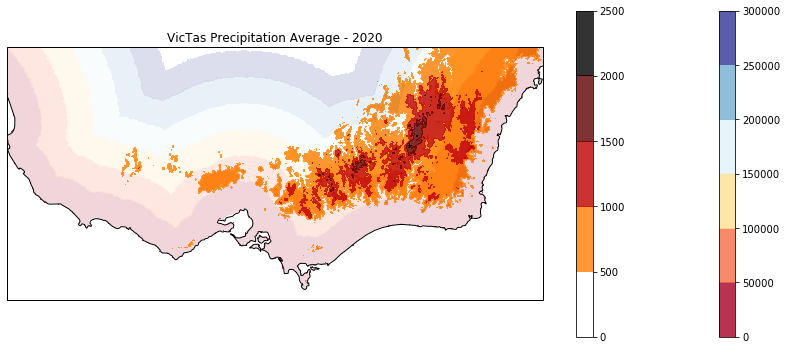

In [23]:
fig,ax=plt.subplots(figsize=(15,12),subplot_kw={'projection':target_proj_v})
dem_plot = sel_d_full_ds.distance.plot.contourf(levels=8,cmap='RdYlBu',add_colorbar=False,ax=ax,add_labels=True,alpha=0.8)
freq_plot = sel_full_ds.dem.plot.contourf(levels=6,cmap='gist_heat_r',add_colorbar=False,ax=ax,add_labels=True,alpha=0.8)
plt.colorbar(dem_plot, shrink=0.5)
plt.colorbar(freq_plot, shrink=0.5)
ax.coastlines('10m')
ax.set_title('VicTas Precipitation Average - 2020')
plt.show()

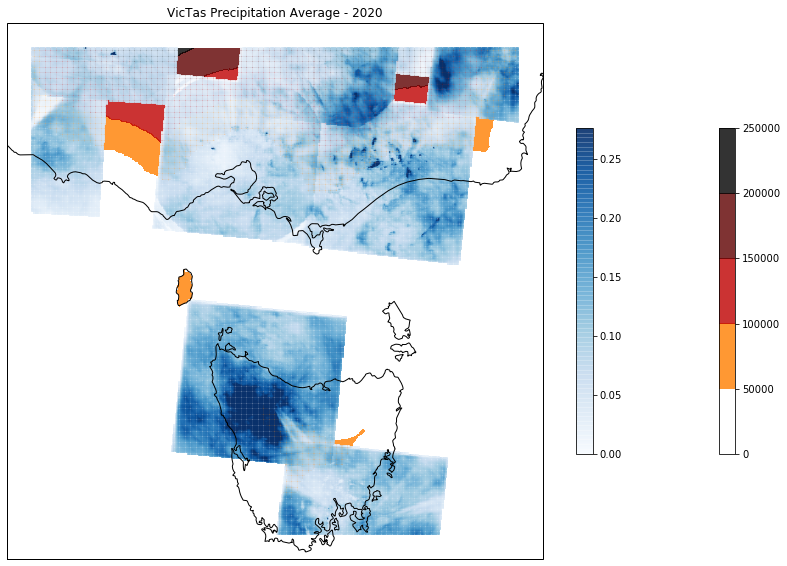

In [36]:
fig,ax=plt.subplots(figsize=(15,12),subplot_kw={'projection':target_proj_v})
dem_plot = sel_d_full_ds.isel(x=slice(50,450),y=slice(50,450)).distance.plot.contourf(levels=6,cmap='gist_heat_r',add_colorbar=False,ax=ax,add_labels=True,alpha=0.8)
freq_plot = sel_d_full_ds.sel(hour=0).isel(x=slice(50,450),y=slice(50,450)).precipitation.plot(ax=ax,add_colorbar=False,cmap='Blues',
            alpha=0.7,robust=True,vmin=0,)
plt.colorbar(dem_plot, shrink=0.5)
plt.colorbar(freq_plot, shrink=0.5)
ax.coastlines('10m')
ax.set_title('VicTas Precipitation Average - 2020')
plt.show()

In [25]:
mean_hour_ds_v = xr.where(d==np.nan,np.nan,s)
mean_hour_ds_v

array([[[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        ...,
        [0.06754144, 0.07016575, 0.07762431, ..., 0.19254145,
         0.17638122, 0.15649171],
        [0.07030386, 0.07154696, 0.0781768 , ..., 0.17928179,
         0.16187847, 0.15483426],
        [0.07251381, 0.0711326 , 0.07320443, ..., 0.17251383,
         0.17651933, 0.17306629]],

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        ...,
        [0.08071625, 0.07947659, 0.08002754, ..., 0.18278237,
         0.18112947, 0.18443525],
        [0.0

In [26]:
dis_ds_v = xr.where(mean_hour_ds_v==np.nan,np.nan,d)
dis_ds_v

array([[[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        ...,
        [48083.26  , 49517.67  , 50911.688 , ...,  5656.8545,
          5656.8545,  4000.    ],
        [50911.688 , 50911.688 , 52345.008 , ...,  8246.211 ,
          6324.555 ,  4472.1357],
        [52345.008 , 53740.117 , 55172.457 , ...,  8944.271 ,
          7211.1025,  5656.8545]],

       [[       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        [       nan,        nan,        nan, ...,        nan,
                nan,        nan],
        ...,
        [48083.26  , 49517.67  , 50911.688 , ...,  5656.8545,
          5656.8545,  4000.    ],
        [509

In [27]:
dis_dem = xr.where(t==np.nan,np.nan,d)
dis_dem

array([[       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       ...,
       [48083.26  , 49517.67  , 50911.688 , ...,  5656.8545,  5656.8545,
         4000.    ],
       [50911.688 , 50911.688 , 52345.008 , ...,  8246.211 ,  6324.555 ,
         4472.1357],
       [52345.008 , 53740.117 , 55172.457 , ...,  8944.271 ,  7211.1025,
         5656.8545]], dtype=float32)

In [28]:
topo_dis = xr.where(dis_dem==np.nan,np.nan,t)
topo_dis

array([[       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       ...,
       [ 19.48069 ,  18.05345 ,  16.42616 , ...,  76.59721 ,  52.34126 ,
         24.72227 ],
       [ 11.6442  ,  13.9853  ,  15.66462 , ..., 357.9852  ,  48.9416  ,
         20.40425 ],
       [  7.437441,   8.403989,  11.27083 , ..., 479.9012  , 205.0974  ,
         33.26088 ]], dtype=float32)

In [29]:
#calculate mean precipitation per distance bins
distance_bins=np.append(-1000, np.arange(0, 300000, 10000))
label_bins=np.append([0], np.arange(5000,290000, 10000))

In [30]:
len(distance_bins)

31

In [31]:
len(label_bins)

30

In [32]:
label_bins

array([     0,   5000,  15000,  25000,  35000,  45000,  55000,  65000,
        75000,  85000,  95000, 105000, 115000, 125000, 135000, 145000,
       155000, 165000, 175000, 185000, 195000, 205000, 215000, 225000,
       235000, 245000, 255000, 265000, 275000, 285000])

In [37]:
hour_mean_precip_per_bin_v = sel_d_full_ds.groupby_bins("distance",distance_bins,labels=label_bins).mean(dim=['stacked_y_x']).precipitation

In [38]:
hour_mean_precip_per_bin_v.distance_bins

<xarray.DataArray 'distance_bins' (distance_bins: 30)>
array([     0,   5000,  15000,  25000,  35000,  45000,  55000,  65000,  75000,
        85000,  95000, 105000, 115000, 125000, 135000, 145000, 155000, 165000,
       175000, 185000, 195000, 205000, 215000, 225000, 235000, 245000, 255000,
       265000, 275000, 285000])
Coordinates:
  * distance_bins  (distance_bins) int64 0 5000 15000 ... 265000 275000 285000

Text(0.5, 1.0, 'Inland Distance Profile at each hour')

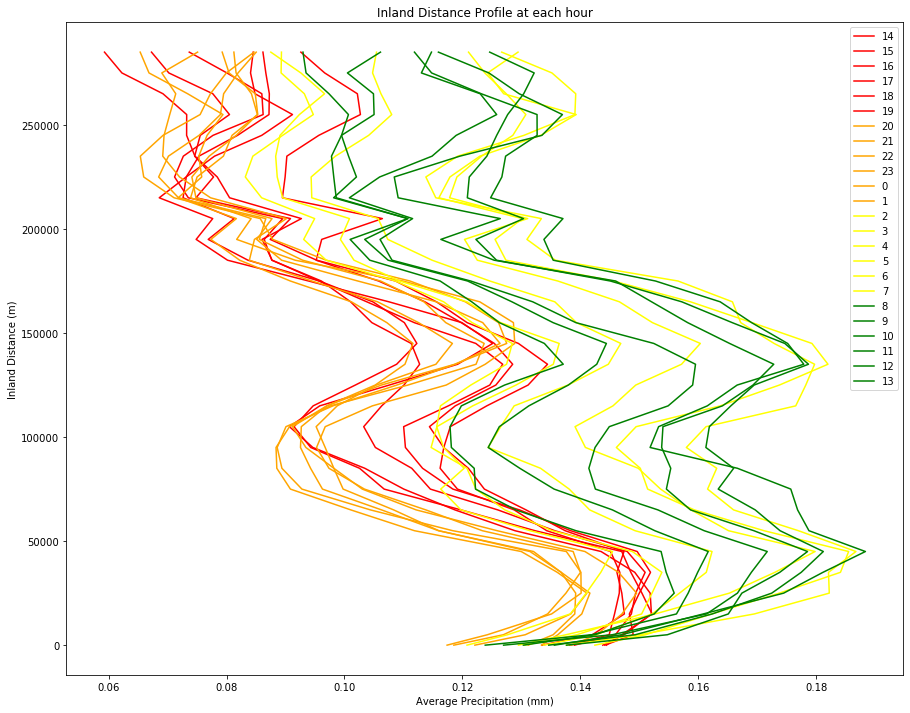

In [39]:
fig, ax=plt.subplots(figsize=(15,12))
for num in range(6):
    ax.plot(hour_mean_precip_per_bin_v.sel(hour=num+14),hour_mean_precip_per_bin_v.sel(hour=num+14).distance_bins,color='red')
for num in range(4):
    ax.plot(hour_mean_precip_per_bin_v.sel(hour=num+20),hour_mean_precip_per_bin_v.sel(hour=num+20).distance_bins,color='orange')
for num in range(2):
    ax.plot(hour_mean_precip_per_bin_v.sel(hour=num),hour_mean_precip_per_bin_v.sel(hour=num).distance_bins,color='orange')
for num in range(6):
    ax.plot(hour_mean_precip_per_bin_v.sel(hour=num+2),hour_mean_precip_per_bin_v.sel(hour=num+2).distance_bins,color='yellow')
for num in range(6):
    ax.plot(hour_mean_precip_per_bin_v.sel(hour=num+8),hour_mean_precip_per_bin_v.sel(hour=num+8).distance_bins,color='green')
ax.legend([14,15,16,17,18,19,20,21,22,23,0,1,2,3,4,5,6,7,8,9,10,11,12,13])
ax.set_xlabel('Average Precipitation (mm)')
ax.set_ylabel('Inland Distance (m)')
ax.set_title('Inland Distance Profile at each hour')

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="ticks")

#y = full_hourly_mean_ds.distance.data.values
#x = full_hourly_mean_ds.sel(hour=0).precipitation.data.ravel()

plot = sns.jointplot(x=sum_ds_v.ravel(), y=dis_ds_v.ravel(), kind="hex",cmap="ocean_r",dropna=True,xlim=(0,3000),ylim=(0,300000),gridsize=(120,40),hue_norm=(0,10),bins="log")
plot.ax_joint.set_ylabel('Inland Distance (m)')
plot.ax_joint.set_xlabel('Total Precipitation (mm)')
plot.fig.suptitle('VicTas Total precipitation against inland distance')
plot.ax_joint.plot(sum_precip_per_bin_v,sum_precip_per_bin_v.distance_bins,color='yellow')

plt.show()
plt.close()

NameError: name 'sum_ds_v' is not defined

In [41]:
topo_precip_per_bin_v = full_dem_ds.drop(['y_bounds','x_bounds']).groupby_bins("dem",distance_bins,labels=label_bins).mean(dim=['stacked_y_x']).precipitation
topo_precip_per_bin_v

ValueError: One or more of the specified variables cannot be found in this dataset

NameError: name 'topo_precip_per_bin_v' is not defined

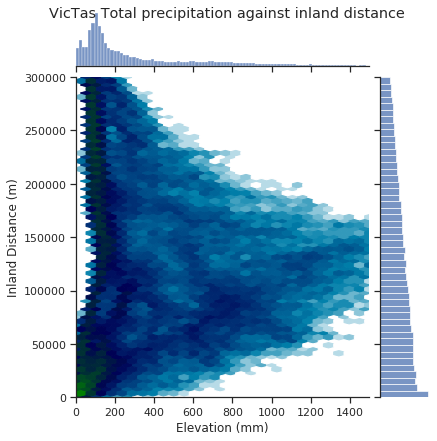

In [42]:
plot = sns.jointplot(x=topo_dis.ravel(), y=dis_dem.ravel(), kind="hex",cmap="ocean_r",dropna=True,xlim=(0,1500),ylim=(0,300000),gridsize=(40,40),hue_norm=(0,10),bins="log")
plot.ax_joint.set_ylabel('Inland Distance (m)')
plot.ax_joint.set_xlabel('Elevation (mm)')
plot.fig.suptitle('VicTas Total precipitation against inland distance')
plot.ax_joint.plot(topo_precip_per_bin_v,topo_precip_per_bin_v.dem_bins,color='yellow')

plt.show()
plt.close()

In [43]:
victas_sum = xr.open_dataset("/home/565/dm2042/WIL/Scatter-plot-data/victas_sum.nc")
victas_sum

<xarray.Dataset>
Dimensions:        (n2: 2, x: 512, y: 512)
Coordinates:
  * x              (x) float64 6.89e+05 6.91e+05 ... 1.709e+06 1.711e+06
  * y              (y) float64 -4.911e+06 -4.909e+06 ... -3.891e+06 -3.889e+06
Dimensions without coordinates: n2
Data variables:
    proj           (y, x) float64 ...
    y_bounds       (y, n2, x) float64 ...
    x_bounds       (x, n2, y) float64 ...
    precipitation  (y, x) float32 ...

In [44]:
_, victas_sum_ds_v = xr.align(victas_tile_ds,victas_sum,join='left',)
victas_sum_ds_v

<xarray.Dataset>
Dimensions:        (n2: 2, x: 512, y: 512)
Coordinates:
  * x              (x) float64 6.89e+05 6.91e+05 ... 1.709e+06 1.711e+06
  * y              (y) float64 -4.911e+06 -4.909e+06 ... -3.891e+06 -3.889e+06
Dimensions without coordinates: n2
Data variables:
    proj           (y, x) float64 nan nan nan nan nan ... 0.0 0.0 0.0 0.0 0.0
    y_bounds       (y, n2, x) float64 nan nan nan ... -1.699e+07 -1.699e+07
    x_bounds       (x, n2, y) float64 nan nan nan ... 7.478e+06 7.478e+06
    precipitation  (y, x) float32 nan nan nan nan ... 2052.45 2039.05 1983.95

In [45]:
coastal_dist_ds

<xarray.Dataset>
Dimensions:   (x: 2450, y: 2050)
Coordinates:
    lon       (y, x) float64 dask.array<chunksize=(2050, 2450), meta=np.ndarray>
    lat       (y, x) float64 dask.array<chunksize=(2050, 2450), meta=np.ndarray>
  * x         (x) float64 -2.299e+06 -2.297e+06 ... 2.597e+06 2.599e+06
  * y         (y) float64 -1.001e+06 -1.003e+06 ... -5.097e+06 -5.099e+06
Data variables:
    distance  (y, x) float32 dask.array<chunksize=(2050, 2450), meta=np.ndarray>

In [46]:
full_sum_ds = victas_sum_ds_v.assign(distance = coastal_dist_ds.distance)
full_sum_ds

<xarray.Dataset>
Dimensions:        (n2: 2, x: 512, y: 512)
Coordinates:
  * x              (x) float64 6.89e+05 6.91e+05 ... 1.709e+06 1.711e+06
  * y              (y) float64 -4.911e+06 -4.909e+06 ... -3.891e+06 -3.889e+06
    lon            (y, x) float64 dask.array<chunksize=(512, 512), meta=np.ndarray>
    lat            (y, x) float64 dask.array<chunksize=(512, 512), meta=np.ndarray>
Dimensions without coordinates: n2
Data variables:
    proj           (y, x) float64 nan nan nan nan nan ... 0.0 0.0 0.0 0.0 0.0
    y_bounds       (y, n2, x) float64 nan nan nan ... -1.699e+07 -1.699e+07
    x_bounds       (x, n2, y) float64 nan nan nan ... 7.478e+06 7.478e+06
    precipitation  (y, x) float32 nan nan nan nan ... 2052.45 2039.05 1983.95
    distance       (y, x) float32 dask.array<chunksize=(512, 512), meta=np.ndarray>

In [47]:
full_sum_dem_ds = full_sum_ds.assign(dem = topo_v.drop(['lat','lon']))
full_sum_dem_ds

<xarray.Dataset>
Dimensions:        (n2: 2, x: 512, y: 512)
Coordinates:
  * x              (x) float64 6.89e+05 6.91e+05 ... 1.709e+06 1.711e+06
  * y              (y) float64 -4.911e+06 -4.909e+06 ... -3.891e+06 -3.889e+06
    lon            (y, x) float64 dask.array<chunksize=(512, 512), meta=np.ndarray>
    lat            (y, x) float64 dask.array<chunksize=(512, 512), meta=np.ndarray>
Dimensions without coordinates: n2
Data variables:
    proj           (y, x) float64 nan nan nan nan nan ... 0.0 0.0 0.0 0.0 0.0
    y_bounds       (y, n2, x) float64 nan nan nan ... -1.699e+07 -1.699e+07
    x_bounds       (x, n2, y) float64 nan nan nan ... 7.478e+06 7.478e+06
    precipitation  (y, x) float32 nan nan nan nan ... 2052.45 2039.05 1983.95
    distance       (y, x) float32 dask.array<chunksize=(512, 512), meta=np.ndarray>
    dem            (y, x) float32 nan nan nan nan ... 479.9012 205.0974 33.26088

In [48]:
sel_full_sum_dem_ds = full_sum_dem_ds.isel(x=slice(0,512),y=slice(270,512))

In [49]:
#calculate mean precipitation per distance bins
distance_bins_e=np.append(0, np.arange(10000, 310000, 10000))
label_bins_e=np.append([0], np.arange(10000,300000, 10000))

In [50]:
len(distance_bins_e)

31

In [51]:
distance_bins_e

array([     0,  10000,  20000,  30000,  40000,  50000,  60000,  70000,
        80000,  90000, 100000, 110000, 120000, 130000, 140000, 150000,
       160000, 170000, 180000, 190000, 200000, 210000, 220000, 230000,
       240000, 250000, 260000, 270000, 280000, 290000, 300000])

In [52]:
len(label_bins_e)

30

In [53]:
label_bins_e

array([     0,  10000,  20000,  30000,  40000,  50000,  60000,  70000,
        80000,  90000, 100000, 110000, 120000, 130000, 140000, 150000,
       160000, 170000, 180000, 190000, 200000, 210000, 220000, 230000,
       240000, 250000, 260000, 270000, 280000, 290000])

In [54]:
topo_precip_per_bin_v = sel_full_sum_dem_ds.groupby_bins("distance",distance_bins_e,labels=label_bins_e).mean(dim=['stacked_y_x']).dem
max(topo_precip_per_bin_v)
# .drop(['y_bounds','x_bounds'])

<xarray.DataArray 'dem' ()>
array(552.40607, dtype=float32)
Coordinates:
    distance_bins  int64 120000

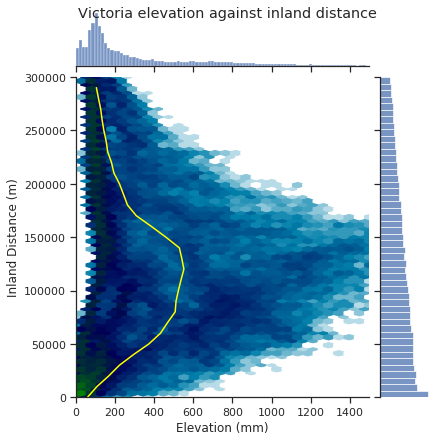

In [55]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="ticks")

plot = sns.jointplot(x=topo_dis.ravel(), y=dis_dem.ravel(), kind="hex",cmap="ocean_r",dropna=True,xlim=(0,1500),ylim=(0,300000),gridsize=(40,40),hue_norm=(0,10),bins="log")
plot.ax_joint.set_ylabel('Inland Distance (m)')
plot.ax_joint.set_xlabel('Elevation (mm)')
plot.fig.suptitle('Victoria elevation against inland distance')
plot.ax_joint.plot(topo_precip_per_bin_v,topo_precip_per_bin_v.distance_bins,color='yellow')

plt.show()
plt.close()

Text(0.5, 0.98, 'Victoria')

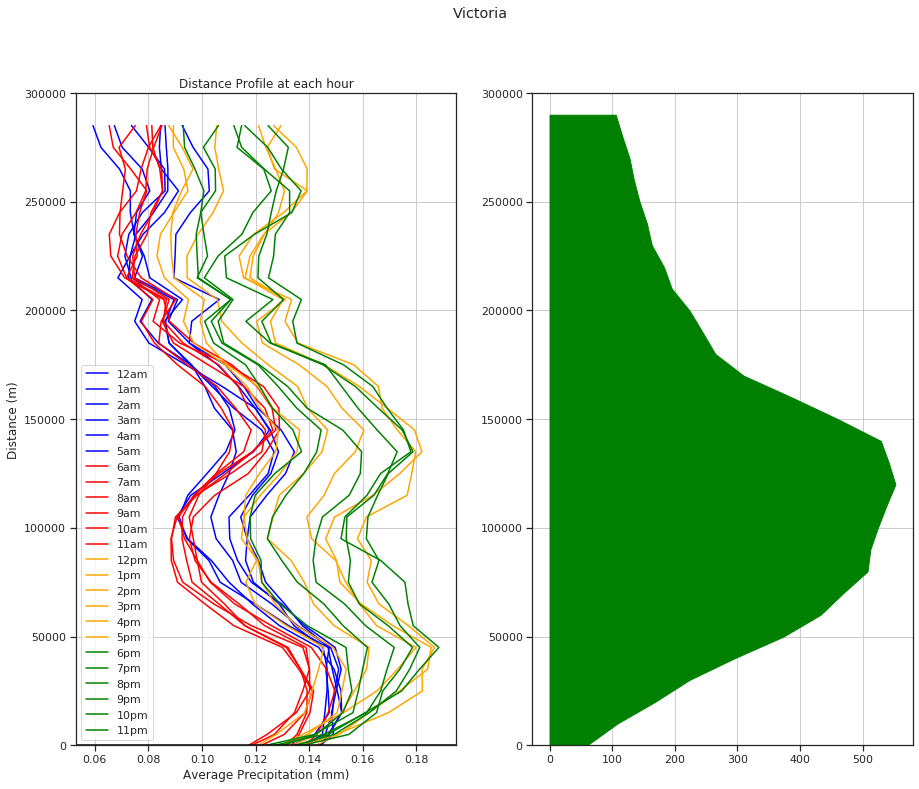

In [90]:
fig, (ax1,ax2)=plt.subplots(1,2,figsize=(15,12))
for num in range(6):
    ax1.plot(hour_mean_precip_per_bin_v.sel(hour=num+14),hour_mean_precip_per_bin_v.sel(hour=num+14).distance_bins,color='blue')
for num in range(4):
    ax1.plot(hour_mean_precip_per_bin_v.sel(hour=num+20),hour_mean_precip_per_bin_v.sel(hour=num+20).distance_bins,color='red')
for num in range(2):
    ax1.plot(hour_mean_precip_per_bin_v.sel(hour=num),hour_mean_precip_per_bin_v.sel(hour=num).distance_bins,color='red')
for num in range(6):
    ax1.plot(hour_mean_precip_per_bin_v.sel(hour=num+2),hour_mean_precip_per_bin_v.sel(hour=num+2).distance_bins,color='orange')
for num in range(6):
    ax1.plot(hour_mean_precip_per_bin_v.sel(hour=num+8),hour_mean_precip_per_bin_v.sel(hour=num+8).distance_bins,color='green')
ax2.fill_betweenx(topo_precip_per_bin_v.distance_bins,topo_precip_per_bin_v,x2=0,color='green')
ax1.legend(['12am','1am','2am','3am','4am','5am','6am','7am','8am','9am','10am','11am','12pm','1pm','2pm','3pm','4pm','5pm','6pm','7pm','8pm','9pm','10pm','11pm'])
ax1.set_ylim(0, 300000)
ax2.set_ylim(0, 300000)
ax1.set_xlabel('Average Precipitation (mm)')
ax1.set_ylabel('Distance (m)')
ax1.set_title('Distance Profile at each hour')
ax1.axhline(y=0,color='black')
ax1.grid()
ax2.grid()
fig.suptitle('Victoria')

Text(0.5, 0.98, 'Victoria')

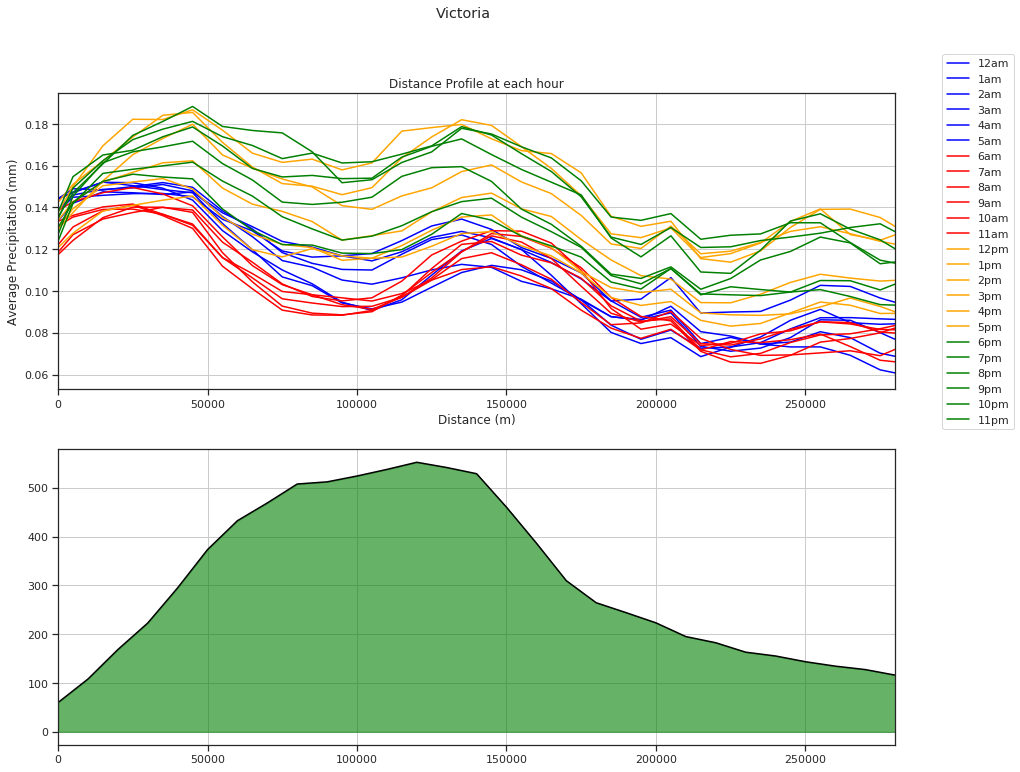

In [98]:
fig, (ax1,ax2)=plt.subplots(2,1,figsize=(15,12))
for num in range(6):
    ax1.plot(hour_mean_precip_per_bin_v.sel(hour=num+14).distance_bins,hour_mean_precip_per_bin_v.sel(hour=num+14),color='blue')
for num in range(4):
    ax1.plot(hour_mean_precip_per_bin_v.sel(hour=num+20).distance_bins,hour_mean_precip_per_bin_v.sel(hour=num+20),color='red')
for num in range(2):
    ax1.plot(hour_mean_precip_per_bin_v.sel(hour=num).distance_bins,hour_mean_precip_per_bin_v.sel(hour=num),color='red')
for num in range(6):
    ax1.plot(hour_mean_precip_per_bin_v.sel(hour=num+2).distance_bins,hour_mean_precip_per_bin_v.sel(hour=num+2),color='orange')
for num in range(6):
    ax1.plot(hour_mean_precip_per_bin_v.sel(hour=num+8).distance_bins,hour_mean_precip_per_bin_v.sel(hour=num+8),color='green')
ax2.fill_between(topo_precip_per_bin_v.distance_bins,topo_precip_per_bin_v,y2=0,color='green',alpha=0.6)
ax2.plot(topo_precip_per_bin_v.distance_bins,topo_precip_per_bin_v,color='black')
ax1.legend(['12am','1am','2am','3am','4am','5am','6am','7am','8am','9am','10am','11am','12pm','1pm','2pm','3pm','4pm','5pm','6pm','7pm','8pm','9pm','10pm','11pm'],bbox_to_anchor=(1.05,1.15))
ax1.set_xlim(0, 280000)
ax2.set_xlim(0, 280000)
ax1.set_ylabel('Average Precipitation (mm)')
ax1.set_xlabel('Distance (m)')
ax1.set_title('Distance Profile at each hour')
ax1.axvline(x=0,color='black')
ax1.grid()
ax2.grid()
fig.suptitle('Victoria')

In [ ]:
sel_tas_ds = full_ds.isel(x=slice(160,400),y=slice(0,240))
sel_tas_ds

In [ ]:
fig,ax=plt.subplots(figsize=(15,12),subplot_kw={'projection':target_proj_v})
dem_plot = sel_tas_ds.distance.plot.contourf(levels=6,cmap='gist_heat_r',add_colorbar=False,ax=ax,add_labels=True,alpha=0.8)
freq_plot = sel_tas_ds.precipitation.plot(ax=ax,add_colorbar=False,cmap='Blues',
            alpha=0.7,robust=True,vmin=0,)
plt.colorbar(dem_plot, shrink=0.5)
plt.colorbar(freq_plot, shrink=0.5)
ax.coastlines('10m')
ax.set_title('VicTas Precipitation Average - 2020')
plt.show()

In [ ]:
plot = sns.jointplot(x=sum_ds_v.ravel(), y=dis_ds_v.ravel(), kind="hex",cmap="ocean_r",dropna=True,xlim=(0,3000),ylim=(0,300000),gridsize=(120,40),hue_norm=(0,10),bins="log")
plot.ax_joint.set_ylabel('Inland Distance (m)')
plot.ax_joint.set_xlabel('Total Precipitation (mm)')
plot.fig.suptitle('VicTas Total precipitation against inland distance')
plot.ax_joint.plot(sum_precip_per_bin_v,sum_precip_per_bin_v.distance_bins,color='yellow')

plt.show()
plt.close()

AttributeError: 'PathCollection' object has no property 'nd'

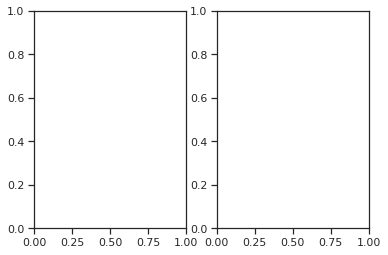

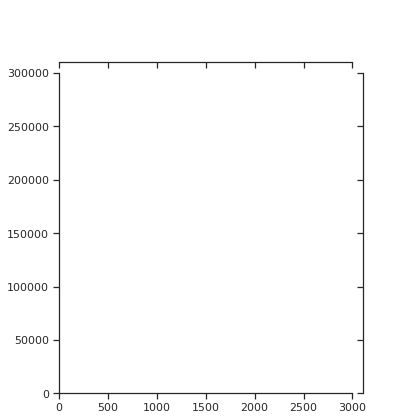

In [44]:
fig, axs=plt.subplots(1,2)

sns.jointplot(x=sum_ds_v.ravel(), y=dis_ds_v.ravel(), ax=axs[0], nd="hex",cmap="ocean_r",dropna=True,xlim=(0,3000),ylim=(0,300000),gridsize=(120,40),hue_norm=(0,10),bins="log")
axs[0].ax_joint.set_ylabel('Inland Distance (m)')
axs[0].ax_joint.set_xlabel('Total Precipitation (mm)')
fig.suptitle('VicTas Total precipitation against inland distance')
axs[0].ax_joint.plot(sum_precip_per_bin_v,sum_precip_per_bin_v.distance_bins,color='yellow')

plt.show()
plt.close()